In [15]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,Input,Add
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Loading and Visualizing the Data
Fetching the mnist from tensorflow
MNIST (Modified National Institute of Standards and Technology) is a dataset that consists of a large collection of handwritten digit images.
The MNIST dataset contains a training set of 60,000 grayscale images and a test set of 10,000 grayscale images. Each image in the dataset is a 28x28-pixel square, representing a handwritten digit from 0 to 9.

In [48]:
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) =tf.keras.datasets.mnist.load_data()


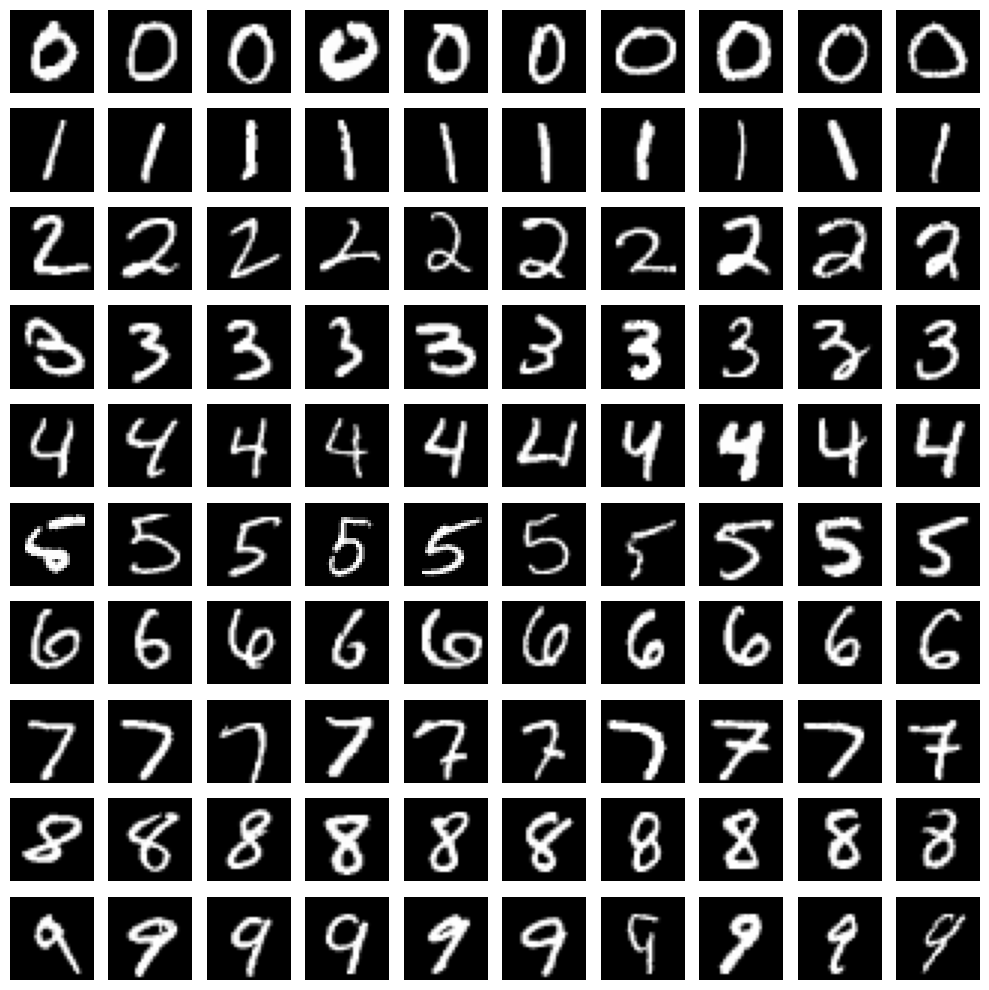

In [29]:
import numpy as np
import matplotlib.pyplot as plt



class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

class_images = {label: [] for label in class_labels}


for image, label in zip(x_test, y_test):
    if len(class_images[label]) < 10:
        class_images[label].append(image)

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, label in enumerate(class_labels):
    for j in range(10):
        axes[i, j].imshow(class_images[label][j], cmap='gray')
        axes[i, j].axis('off')

    axes[i, 0].set_ylabel(f'Class {label}', rotation=0, labelpad=20)

plt.tight_layout()
plt.show()

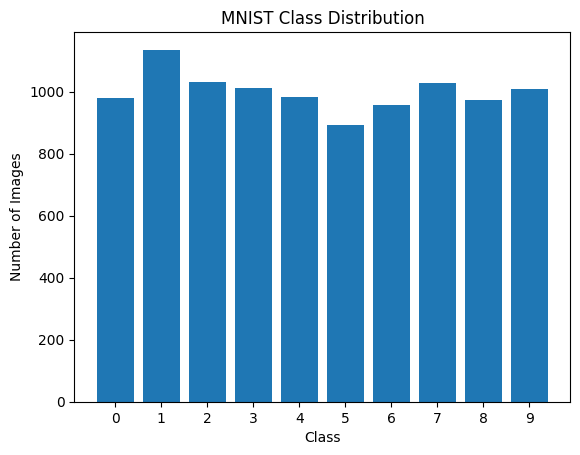

In [30]:
class_counts = np.bincount(y_test)

# Plot the class distribution
fig, ax = plt.subplots()
ax.bar(range(10), class_counts)
ax.set_xticks(range(10))
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('MNIST Class Distribution')

plt.show()

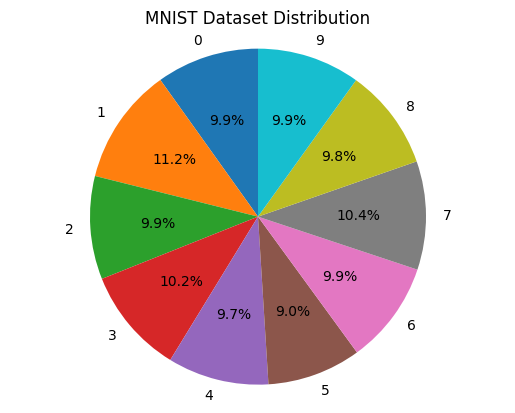

In [49]:

class_counts = np.bincount(y_train)

class_labels = np.arange(len(class_counts))
# Generate pie chart
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10(np.linspace(0, 1, len(class_counts))))
plt.axis('equal')
plt.title('MNIST Dataset Distribution')
plt.show()

# Data Preprocessing
The data preprocessing steps for the MNIST dataset include reshaping the input data and normalizing the pixel values, along with optional steps such as one-hot encoding for multi-class classification and splitting the dataset into training and test sets.

In [46]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [45]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Model Building
This CNN model consists of multiple convolutional blocks, each composed of convolutional layers, skip connections, and max pooling layers. The skip connections help preserve and reuse important features from earlier layers. The model also includes global average pooling and fully connected layers for classification.The dimensionality mismatches between the feature maps are dealt by adding the output of the pooling layer to the extra convolutional layer

In [23]:
# First convolutional block
input_layer = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Second convolutional block
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(conv2)

## Adding the skip connection for conv2
skip_connection = Conv2D(64, kernel_size=(1, 1), activation='relu', padding='same')(pool1)
skip_connection = Add()([conv2, skip_connection])
pool2 = MaxPooling2D(pool_size=(2, 2))(skip_connection)

# Third convolutional block
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# Fourth convolutional block
conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(conv4)

## Adding the skip connection for conv4
skip_connection = Conv2D(256, kernel_size=(1, 1), activation='relu', padding='same')(pool3)
skip_connection = Add()([conv4, skip_connection])
pool4 = MaxPooling2D(pool_size=(2, 2))(skip_connection)

# Global Average Pooling
global_avg_pool = GlobalAveragePooling2D()(pool4)

# Fully connected layers
fc1 = Dense(256, activation='relu')(global_avg_pool)
fc2 = Dense(128, activation='relu')(fc1)
output_layer = Dense(num_classes, activation='softmax')(fc2)  # num_classes is the number of output classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)


In [24]:
model.compile(loss='SparseCategoricalCrossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 28, 28, 32)   320         ['input_8[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 28, 28, 32)   9248        ['conv2d_38[0][0]']              
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_39[0][0]']              
 )                                                                                          

In [21]:
from tensorflow.keras.utils import plot_model

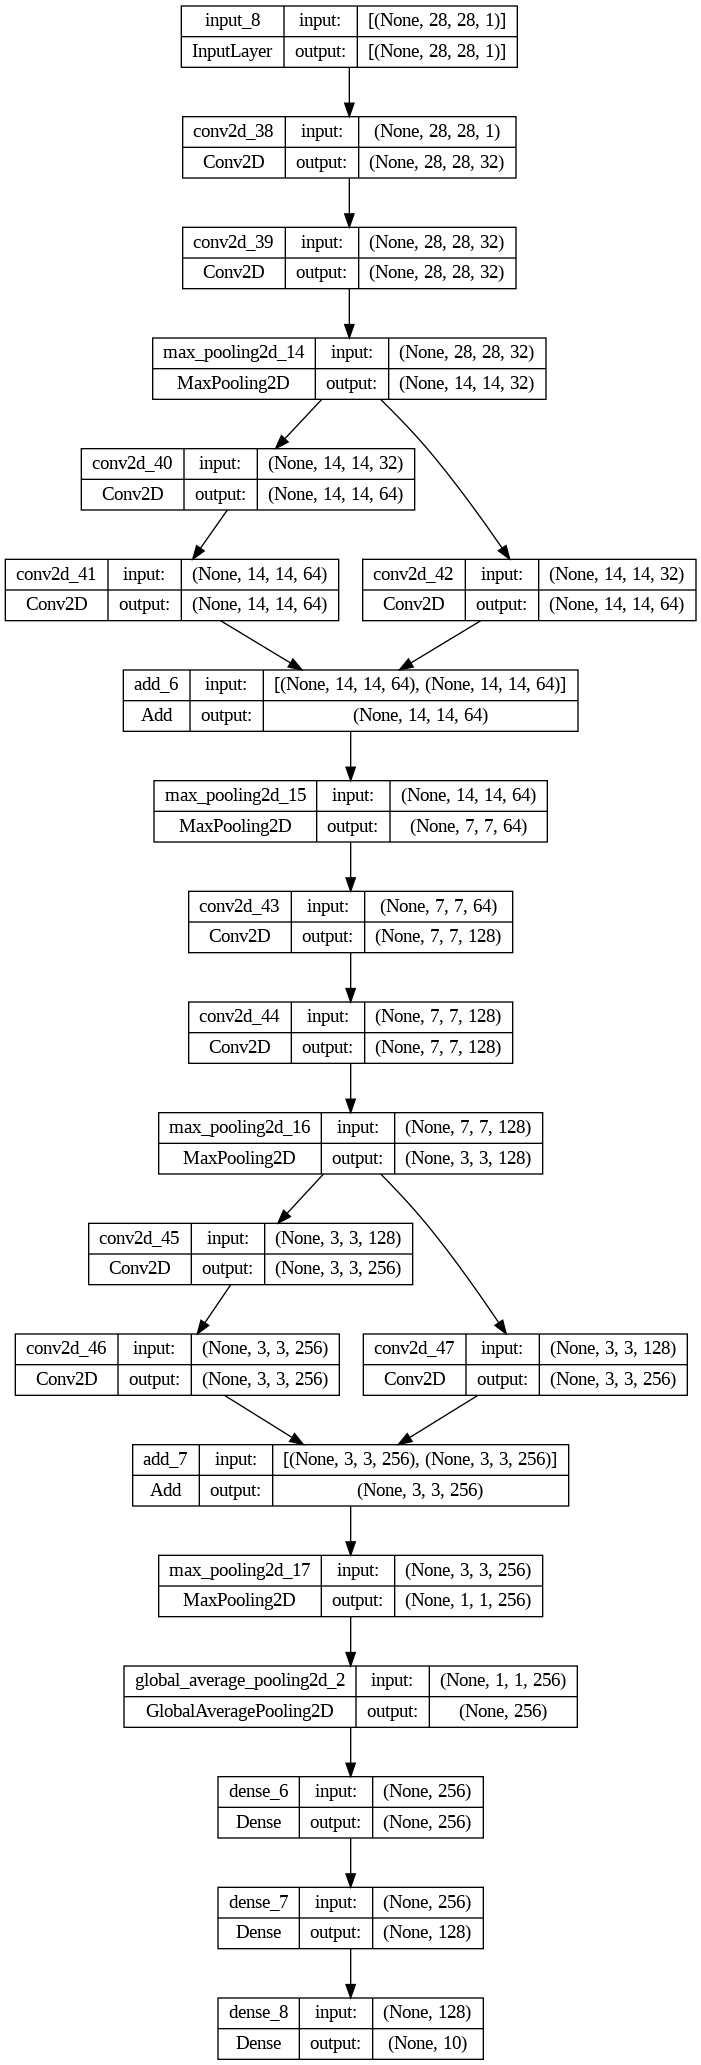

In [26]:
plot_model(model, to_file='custom_cnn_with_skip_connection.png', show_shapes=True)

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [34]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history= model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks = [early_stop])

Epoch 1/15
375/375 [==============================] - 11s 15ms/step - loss: 0.0213 - accuracy: 0.9944 - val_loss: 0.0488 - val_accuracy: 0.9890
Epoch 2/15
375/375 [==============================] - 6s 15ms/step - loss: 0.0200 - accuracy: 0.9942 - val_loss: 0.0489 - val_accuracy: 0.9876
Epoch 3/15
375/375 [==============================] - 5s 14ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.0388 - val_accuracy: 0.9922
Epoch 4/15
375/375 [==============================] - 5s 14ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0404 - val_accuracy: 0.9933
Epoch 5/15
375/375 [==============================] - 6s 15ms/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 0.0327 - val_accuracy: 0.9918
Epoch 6/15
375/375 [==============================] - 6s 15ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.0428 - val_accuracy: 0.9928
Epoch 7/15
375/375 [==============================] - 7s 18ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0372 - val_accuracy: 0.991

In [33]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

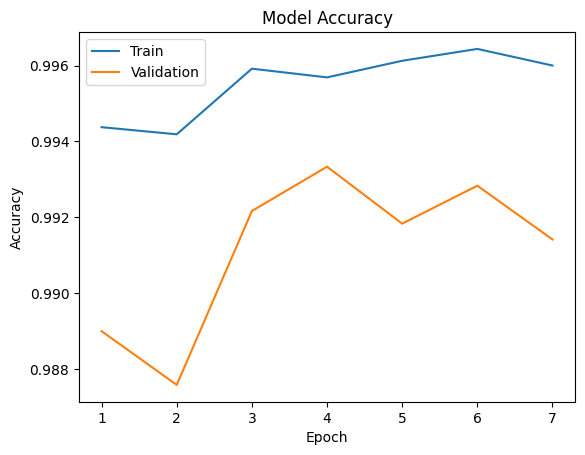

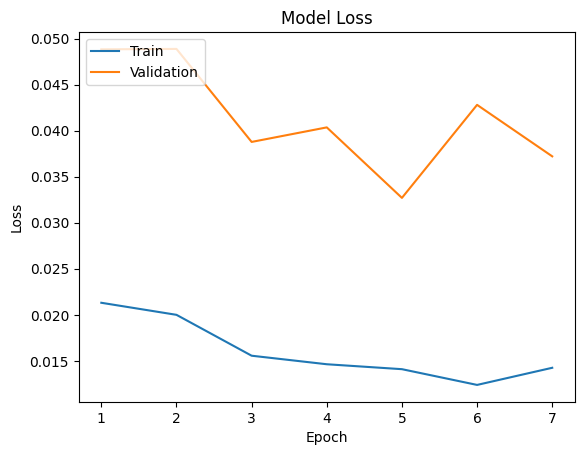

In [35]:
 plotLearningCurve(history,7)

In [36]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.027790283784270287
Test accuracy: 0.9934999942779541


In [41]:
from sklearn.metrics import confusion_matrix

# Prediction


In [37]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 3ms/step


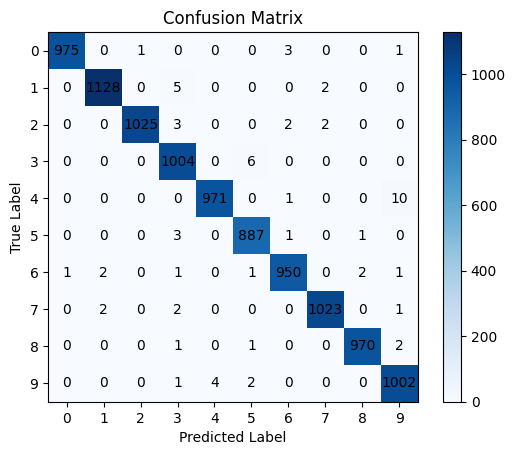

In [42]:
confusion_mat = confusion_matrix(y_true, y_pred_classes)

plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(confusion_mat[i, j]), ha='center', va='center')
plt.show()

1/1 [==============================] - 1s 683ms/step


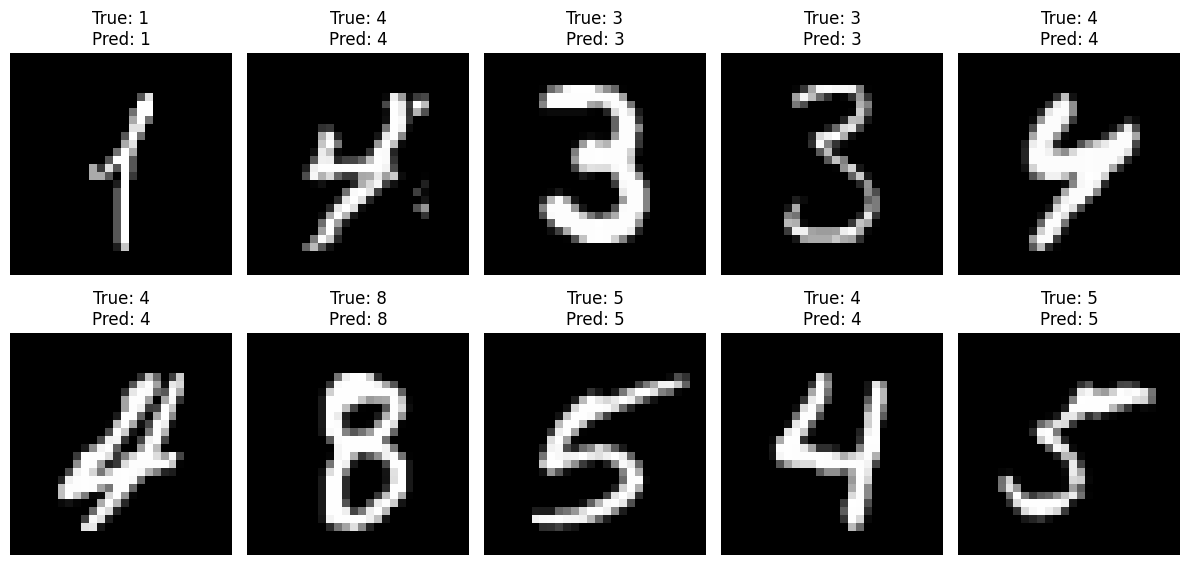

In [44]:
random_indices = np.random.choice(len(x_test), size=10, replace=False)
x_selected = x_test[random_indices]
y_selected_true = np.argmax(y_test[random_indices], axis=1)

#making the preds
y_selected_pred = model.predict(x_selected)
y_selected_pred_classes = np.argmax(y_selected_pred, axis=1)


fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(len(x_selected)):
    axs[i].imshow(x_selected[i].reshape(28, 28), cmap='gray')
    axs[i].set_title(f"True: {y_selected_true[i]}\nPred: {y_selected_pred_classes[i]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()